In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import glob
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# **Display images and ground truth masks**
The data has 5 sets of 1000 images and corresponding labels.

In [3]:
def plot_images_and_masks(data_folder):
    subfolders = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']
    num_images_to_plot = 3

    for subfolder in subfolders:
        image_subfolder_path = os.path.join(data_folder, subfolder, subfolder, 'CameraRGB')
        mask_subfolder_path = os.path.join(data_folder, subfolder, subfolder, 'CameraSeg')

        image_files = os.listdir(image_subfolder_path) 
        mask_files = os.listdir(mask_subfolder_path)

        # print(len(image_files))
        # print(len(mask_files))

        for i in range(num_images_to_plot):
            image_path = os.path.join(image_subfolder_path, image_files[i])
            mask_path = os.path.join(mask_subfolder_path, mask_files[i])

            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Image {i+1} - Subfolder: {subfolder}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask)  # Display mask in grayscale
            plt.title(f'Mask {i+1} - Subfolder: {subfolder}')
            plt.axis('off')

            plt.show()


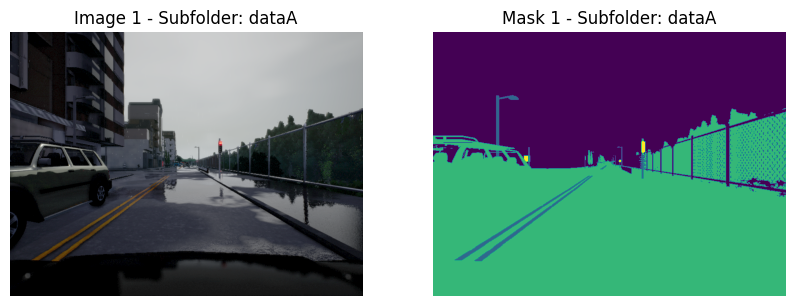

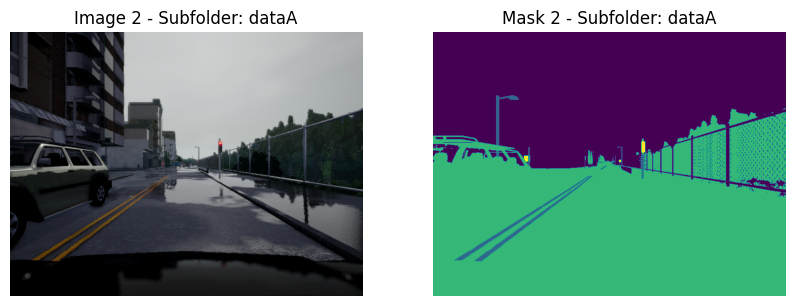

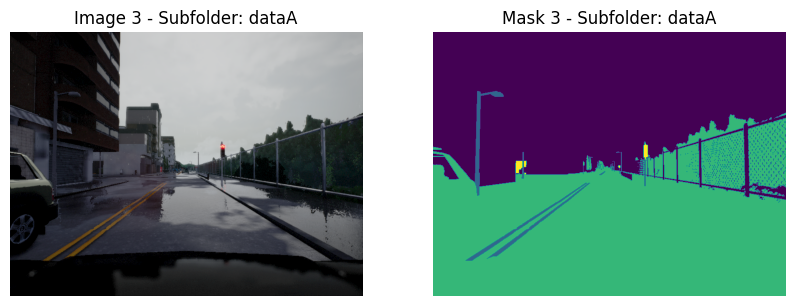

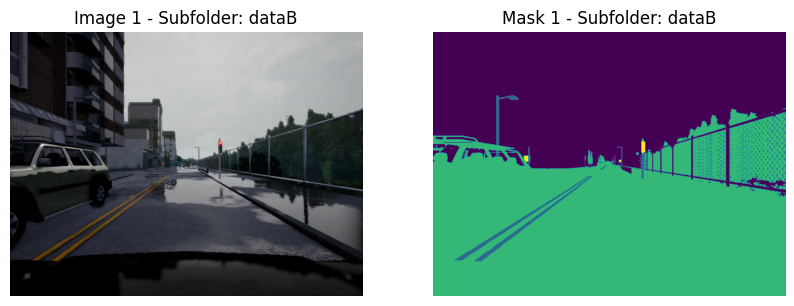

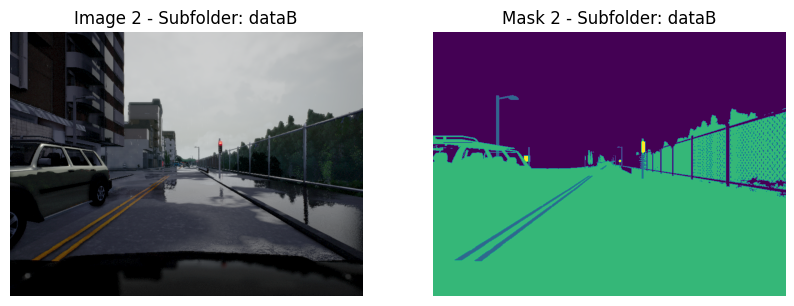

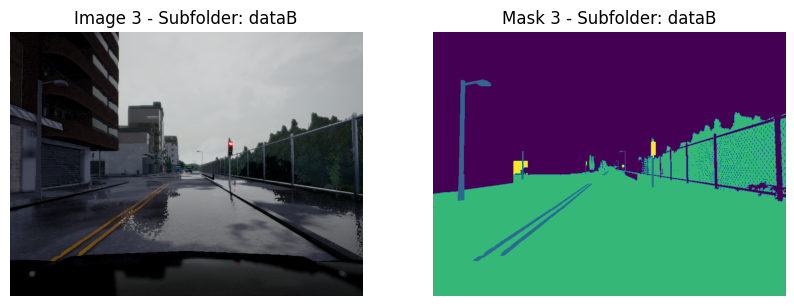

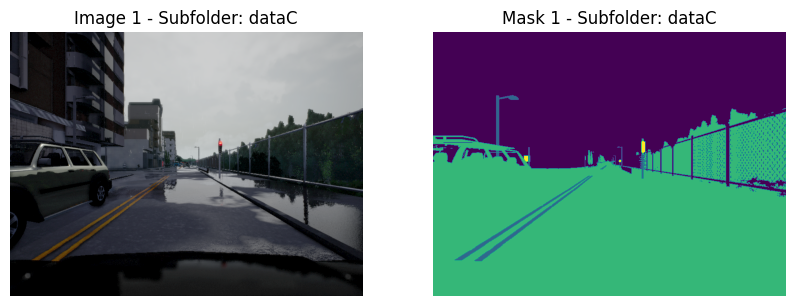

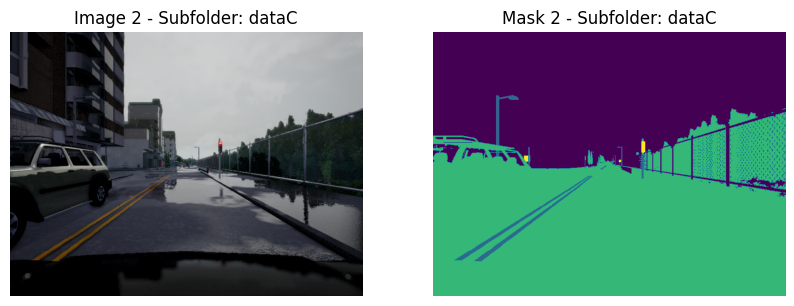

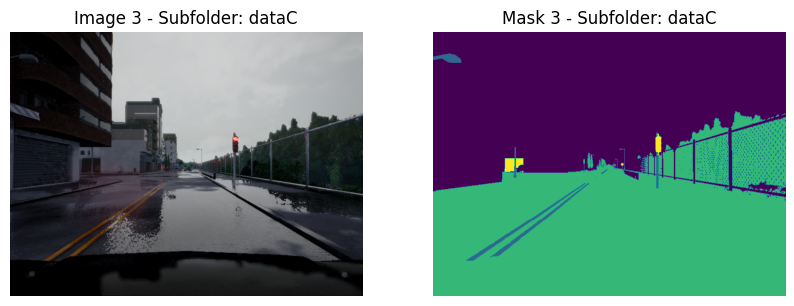

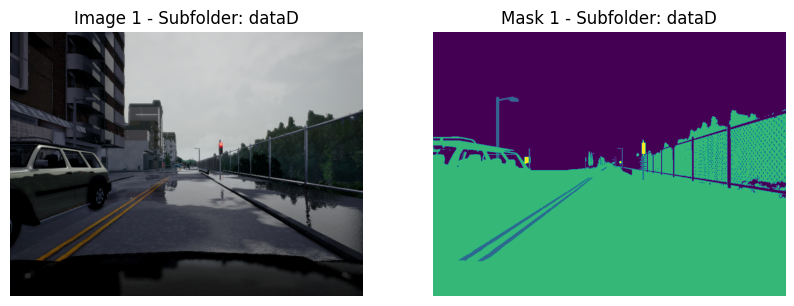

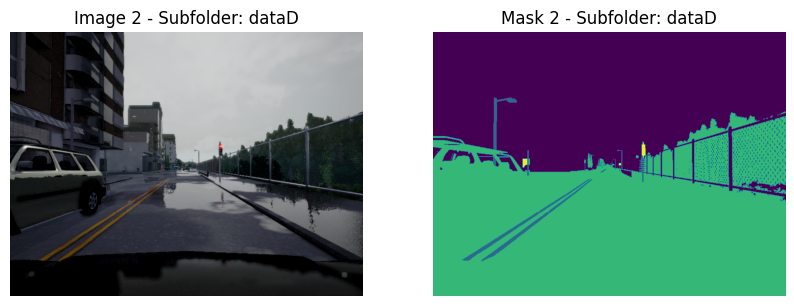

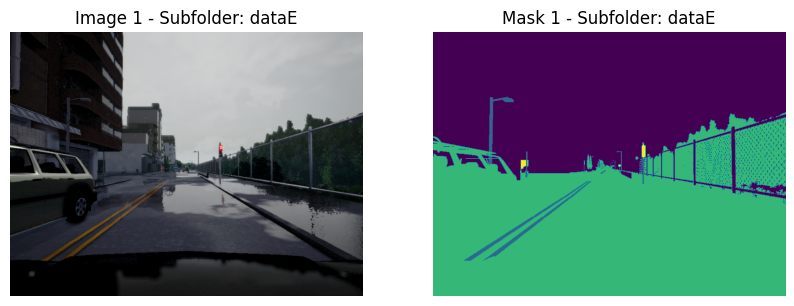

In [4]:
data_folder = "F:\Coding\Sematic_Segmentation_U-net_Autonomus_Driving\Data\Dataset"  #Replace with the path to the parent data folder
plot_images_and_masks(data_folder)

# Storing images and masks in a list

In [5]:
images_list = []
masks_list = []
def store_imgs_masks(data):
    images_list.append(glob.glob('F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\Dataset\\' + data + '\\' + data + '\\CameraRGB\\*.png'))
    masks_list.append(glob.glob('F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\'+ data +'\\'+ data +'\\CameraSeg\\*.png'))


In [6]:
store_imgs_masks('dataA')
store_imgs_masks('dataB')
store_imgs_masks('dataC')
store_imgs_masks('dataD')
store_imgs_masks('dataE')

In [7]:
def get_one_list(list_of_lists):
    
    one_list = []

    for sublist in list_of_lists:
        one_list.extend(sublist)
    return one_list

In [8]:
images_list = get_one_list(images_list)
masks_list = get_one_list(masks_list)

# Converting lists to Tensors so as to use Tensorflow

In [9]:
image_list_ds = tf.data.Dataset.list_files(images_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(masks_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)


(<tf.Tensor: shape=(), dtype=string, numpy=b'F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\dataA\\dataA\\CameraRGB\\02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\dataA\\dataA\\CameraSeg\\02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\dataA\\dataA\\CameraRGB\\02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\dataA\\dataA\\CameraSeg\\02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\dataA\\dataA\\CameraRGB\\02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\dataA\\dataA\\CameraSeg\\02_00_010.png'>)


In [10]:
image_filenames = tf.constant(images_list)
masks_filenames = tf.constant(masks_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\dataA\\dataA\\CameraRGB\\02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'F:\\Coding\\Sematic_Segmentation_U-net_Autonomus_Driving\\Data\\Dataset\\dataA\\dataA\\CameraSeg\\02_00_000.png', shape=(), dtype=string)


# Preprocessing of images and masks

In [11]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (192, 256), method='nearest')
    input_mask = tf.image.resize(mask, (192, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [12]:
uniques = set()

for img, mask in image_ds.take(5000):
    uniques.update(np.unique(mask.numpy()))
    
print("Number of classes: ", uniques)

Number of classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


# Building U-net

In [13]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs) #convolution (Downsampling) layer
    x = BatchNormalization()(x) #Batch normalization
    x = Activation('relu')(x) #ReLU (Rectified Linear Unit) Activation Function
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if pool == True:
        p = MaxPool2D((2,2))(x) #Maxpooling layer
        return x, p # x is filters and p is output feature map obtained after maxpooling
    else:
        return x
    
    
def build_unet(shape, num_classes):   # this function is used to create unet architecture using conv_block function
    inputs = Input(shape)
    
    filters_x = [16,32,48,64,64,48,32,16]
    filters_b = [128] 

    # Encoder : Encoder path consist of 4 blocks
    # Encoder path is used to capture context (feature map) of input image in order to do segmentation
    x1, p1 = conv_block(inputs, filters_x[0], pool=True)
    x2, p2 = conv_block(p1, filters_x[1], pool=True)
    x3, p3 = conv_block(p2, filters_x[2], pool=True)
    x4, p4 = conv_block(p3, filters_x[3], pool=True)    
    
    # Bridge
    b1 = conv_block(p4, filters_b[0], pool=False) #Bridge is used to pass context from Encoder layer to Decoder layer
    
    # Decoder : Decoder path consist of 4 blocks
    # Decoder path is used to reconstruct segmentation image from contracted image obtained from encoder path
    u1 = UpSampling2D((2,2), interpolation='bilinear')(b1) #DeConvolution (upsampling) layer for upsizing image.
    c1 = Concatenate()([u1, x4]) #Concatenation layer - It concatenates current image with corresponding image from encoder path to increase pixel precision.
    x5 = conv_block(c1, filters_x[4], pool=False) #convolution layer with no pooling
    
    u2 = UpSampling2D((2,2), interpolation='bilinear')(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, filters_x[5], pool=False)
    
    u3 = UpSampling2D((2,2), interpolation='bilinear')(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, filters_x[6], pool=False)
    
    u4 = UpSampling2D((2,2), interpolation='bilinear')(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, filters_x[7], pool=False)
    
    # Output Layer
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8) # Output layer to create segmentation image of same size. 
    # 'softmax' activation function is used to classify pixels into different classes

    return Model(inputs, output)

In [14]:
# Define the resolution of the images and the number of classes

H = 192  
W = 256 
num_classes = 13
#calling function to build model
unet = build_unet((H, W, 3), num_classes)  

# Model Summary

In [15]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 192, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 192, 256, 16)         0         ['batch_normalization[0][0

# Compiling models

In [16]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training Model

In [17]:
EPOCHS = 50
BUFFER_SIZE = 1000
BATCH_SIZE = 64
map_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# Splitting data to training set and val set
num_samples = map_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_dataset = map_dataset.take(int(0.8 * num_samples))
val_dataset = map_dataset.skip(int(0.8 * num_samples))
print(processed_image_ds)
# ReduceLROnPlateau and EarlyStopping callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=1, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

<_MapDataset element_spec=(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))>


In [18]:
model_history1 = unet.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr,early_stop])

Epoch 1/50



c:\Users\Akash1\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



63/63 [==============================] - 167s 3s/step - loss: 1.3971 - accuracy: 0.6385 - val_loss: 1.9914 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 159s 3s/step - loss: 0.7367 - accuracy: 0.8970 - val_loss: 2.2284 - val_accuracy: 0.4029 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - 156s 2s/step - loss: 0.4743 - accuracy: 0.9209 - val_loss: 1.5817 - val_accuracy: 0.5580 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - 157s 2s/step - loss: 0.3441 - accuracy: 0.9297 - val_loss: 1.4166 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 5/50
63/63 [==============================] - 155s 2s/step - loss: 0.2749 - accuracy: 0.9388 - val_loss: 1.0670 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 6/50
63/63 [==============================] - 184s 3s/step - loss: 0.2306 - accuracy: 0.9451 - val_loss: 0.9609 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 7/50
63/63 [==============================] - 181s 3s/step - loss: 0.1982 - accu

# Model Performance

In [23]:
def plot_loss_and_accuracy(model_history):
    # Get the training and validation loss and accuracy values from the model history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_loss_and_accuracy(model_history1)

#  Prediction

In [24]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [25]:
def show_predictions(unet = unet, dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 1s 323ms/step


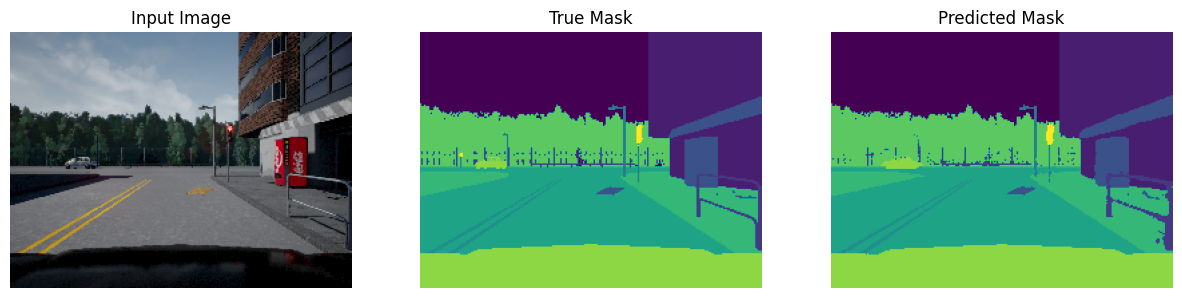

2/2 [==============================] - 1s 306ms/step


2/2 [==============================] - 1s 316ms/step


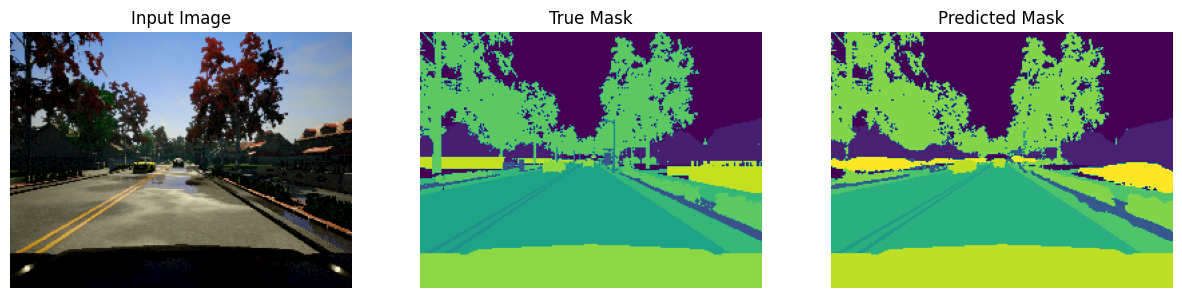

2/2 [==============================] - 1s 315ms/step


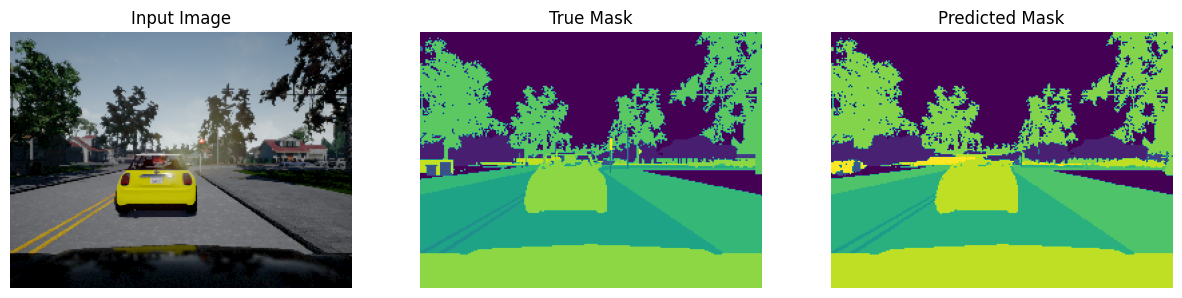

2/2 [==============================] - 1s 302ms/step


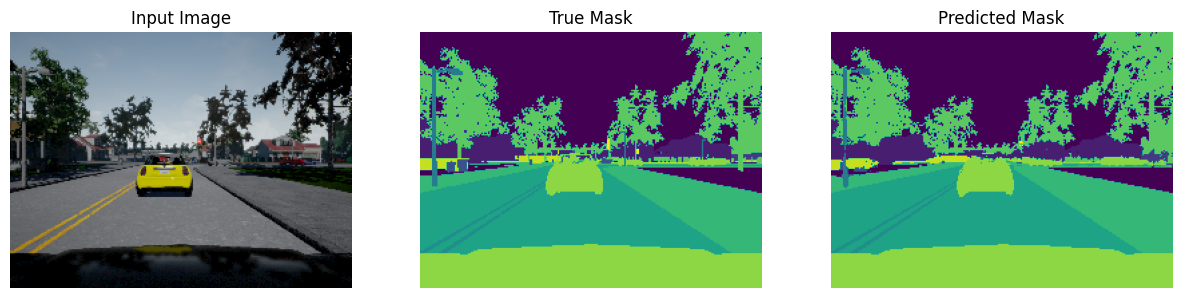

2/2 [==============================] - 1s 316ms/step


In [22]:
show_predictions(unet,train_dataset, 6)

# Saving the model

In [26]:
tf.keras.models.save_model(unet, "F:\Coding\Sematic_Segmentation_U-net_Autonomus_Driving\Model")

INFO:tensorflow:Assets written to: F:\Coding\Sematic_Segmentation_U-net_Autonomus_Driving\Model\assets


INFO:tensorflow:Assets written to: F:\Coding\Sematic_Segmentation_U-net_Autonomus_Driving\Model\assets
